In [1]:
# Library imports
import nltk
import numpy as np
import pandas as pd
import pickle
import sys
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
sys.path.append('../')

# Repository imports.
import LanguageUtils as utils
import LanguageModels
from LanguageModels import DenseNetwork, RecurrentNetwork
import LocalNetBase
import network
import train

%run FF_common.ipynb

In [2]:
BATCH_SIZE = 100
# Global definitions - data
DATA_FN = '../data/crowdflower_data.csv'
LABEL_NAMES = ["happiness", "worry", "neutral", "sadness"]

# Global definitions - architecture
EMBEDDING_DIM = 100  # We will use pretrained 100-dimensional GloVe
NUM_CLASSES = 4
USE_CUDA = torch.cuda.is_available()  # CUDA will be available if using GPU

# Global definitions - saving and loading data
FRESH_START = False  # set this to false after running once with True to just load your preprocessed data from file
#                     (good for debugging)
TEMP_FILE = "temporary_data.pkl"  # if you set FRESH_START to false, the program will look here for your data, etc.

# Make runs consistent (optional)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
def train_model(model, loss_fn, optimizer, train_generator, dev_generator):
    """
    Perform the actual training of the model based on the train and dev sets.
    :param model: one of your models, to be trained to perform 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param optimizer: a created optimizer you will use to update your model weights
    :param train_generator: a DataLoader that provides batches of the training set
    :param dev_generator: a DataLoader that provides batches of the development set
    :return model, the trained model
    """
    # Given a model, data, and loss function:
    # 1) Loop through the whole train dataset performing batch optimization with the optimizer of your choice,
    # updating the model parameters with each batch (we suggest you use torch.optim.Adam to start);
    # 2) Each time you reach the end of the train dataset (one "epoch"), calculate the loss on the whole dev set;
    # 3) stop training and return the model once the development loss stops improving (called early stopping).
    # Print the dev set loss each epoch to stdout.
    # Keep track of the loss
    prev_loss = torch.ones(1) * 1e30 # Initialize high previous cost value
    model = model.train()
#     epoch_count = 0
    while True:
        for X_train, y_train in train_generator:
            optimizer.zero_grad()  # Zero the gradient buffers
            # model.zero_grad()  # Zero the gradient buffers
            output = model(X_train)
            train_loss = loss_fn(output.double(), y_train.long())
            train_loss.backward() # Backpropagation
            optimizer.step()  # Does the update
#         epoch_count += 1
        # Calculate development loss for this epoch
        with torch.no_grad():
            loss = torch.zeros(1)
            for X_dev, y_dev in dev_generator:
                # Predict
                y_pred = model(X_dev)
                # Get dev loss for this batch
                loss += loss_fn(y_pred.double(), y_dev.long()).data
            print("Development Loss: " + str(loss))
            # Implement early stopping
            if loss >= prev_loss:
                break
            prev_loss = loss
#     print(epoch_count)
    return model

In [4]:
def test_model(model, loss_fn, test_generator):
    """
    Evaluate the performance of a model on the development set, providing the loss and macro F1 score.
    :param model: a model that performs 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param test_generator: a DataLoader that provides batches of the testing set
    """
    gold = []
    predicted = []

    # Keep track of the loss
    loss = torch.zeros(1)  # requires_grad = False by default; float32 by default
    if USE_CUDA:
        loss = loss.cuda()

    model.eval()

    # Iterate over batches in the test dataset
    with torch.no_grad():
        for X_b, y_b in test_generator:
            # Predict
            y_pred = model(X_b)

            # Save gold and predicted labels for F1 score - take the argmax to convert to class labels
            gold.extend(y_b.cpu().detach().numpy())
            predicted.extend(y_pred.argmax(1).cpu().detach().numpy())

            loss += loss_fn(y_pred.double(), y_b.long()).data

    # Print total loss and macro F1 score
    print("Test loss: ")
    print(loss)
    print("F-score: ")
    print(f1_score(gold, predicted, average='macro'))
    print("Accuracy score: ")
    print(accuracy_score(gold, predicted))

## Prepare the data and the pretrained embedding matrix

In [5]:
df = pd.read_csv(DATA_FN)
print(df.head())
class_labels = df['sentiment'].values.tolist()
class_labels_set = set(class_labels)
print(df['sentiment'].value_counts()) # print distribution of labels

# split dataset set into evenly distributed upstraem and downstream subsets
X = df['content']
y = df['sentiment']
x_upstream, x_downstream, y_upstream, y_downstream = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
print(y_upstream.value_counts())
print(y_downstream.value_counts())

# create upstream dataset consisting of two emotions 
x_upstream_list = x_upstream.tolist()
y_upstream_list = y_upstream.tolist()

x_upstream_two_class = []
y_upstream_two_class = []
for i in range(1, len(y_upstream)):
    if y_upstream_list[i] in {"worry", "neutral"}:
        x_upstream_two_class.append(x_upstream_list[i])
        y_upstream_two_class.append(y_upstream_list[i])
x_upstream_two_class = pd.Series(x_upstream_two_class)
y_upstream_two_class = pd.Series(y_upstream_two_class)
print(y_upstream_two_class.value_counts())

  sentiment                                            content
0   sadness  Layin n bed with a headache  ughhhh...waitin o...
1   sadness                Funeral ceremony...gloomy friday...
2   neutral  @dannycastillo We want to trade with someone w...
3     worry  Re-pinging @ghostridah14: why didn't you go to...
4   sadness  I should be sleep, but im not! thinking about ...
neutral      8638
worry        8459
happiness    5209
sadness      5165
Name: sentiment, dtype: int64
neutral      4319
worry        4229
happiness    2604
sadness      2583
Name: sentiment, dtype: int64
neutral      4319
worry        4230
happiness    2605
sadness      2582
Name: sentiment, dtype: int64
neutral    4319
worry      4229
dtype: int64


In [6]:
# Convert Series to Dataframes
upstream_df = pd.concat([x_upstream, y_upstream], axis=1)
downstream_df = pd.concat([x_downstream, y_downstream], axis=1)
upstream_2class_df = pd.concat([x_upstream_two_class.rename('content'), y_upstream_two_class.rename('sentiment')], axis=1)

In [7]:
print(downstream_df.head())
print(upstream_2class_df.head())

                                                 content  sentiment
246    I spilled my beer all over my leg. Wasted half...  happiness
9734   @vlastikb logically, yes. i just have to find ...    neutral
25631  @aami1982 probably a bit short on the rude wor...    neutral
10387  Draining my iPhone battery in half a day witho...    sadness
14987  @eddyhendergrass that sounds like the scariest...      worry
                                             content sentiment
0  guess i wasnt on next. now im in 2 songs. 3 gu...   neutral
1  just thought of a spanish name that she will p...   neutral
2  5 things this Twitterer could do without  http...   neutral
3  #millsthemusical  @lauzzaa i hope you've liste...   neutral
4               and its over now  watch on now? hmmm   neutral


In [8]:
if FRESH_START:
    print("Preprocessing all data from scratch....")
    training, dev, test = utils.get_data(DATA_FN)

    # train_data includes .word2idx and .label_enc as fields if you would like to use them at any time
    # get embeddings over whole dataset
    _train_generator, _dev_generator, _test_generator, embeddings, _train_data, _test_data = utils.vectorize_data(training, dev, test,
                                                                                            BATCH_SIZE,
                                                                                            EMBEDDING_DIM)
    
    # get generators and vectors for downstream
    training, dev, test = np.split(downstream_df.sample(frac=1, random_state=42), [int(.8 * len(downstream_df)), int(.9 * len(downstream_df))])
    train_generator, dev_generator, test_generator, _embeddings, train_data_downstream, test_data_downstream = utils.vectorize_data(training, dev, test,
                                                                                            BATCH_SIZE,
                                                                                            EMBEDDING_DIM,
                                                                                            create_embedding = False)
    
    # get vectors for upstream
    training, test = np.split(upstream_df.sample(frac=1, random_state=42), [int(.8 * len(upstream_df))])
    _train_generator, _dev_generator, _test_generator, _embeddings, train_data_upstream, test_data_upstream = utils.vectorize_data(training, pd.DataFrame(), test,
                                                                                            BATCH_SIZE,
                                                                                            EMBEDDING_DIM,
                                                                                            create_embedding = False)
    # get vectors for 2 class upstream
    training, test = np.split(upstream_2class_df.sample(frac=1, random_state=42), [int(.8 * len(upstream_2class_df))])
    _train_generator, _dev_generator, _test_generator, _embeddings, train_data_upstream_two_class, test_data_upstream_two_class = utils.vectorize_data(training, pd.DataFrame(), test,
                                                                                            BATCH_SIZE,
                                                                                            EMBEDDING_DIM,
                                                                                            create_embedding = False)
    
    print("Saving DataLoaders and embeddings so you don't need to create them again; you can set FRESH_START to "
          "False to load them from file....")
    with open(TEMP_FILE, "wb+") as f:
        pickle.dump((train_generator, dev_generator, test_generator, embeddings, train_data_downstream, test_data_downstream, train_data_upstream, test_data_upstream, train_data_upstream_two_class, test_data_upstream_two_class), f)
else:
    try:
        with open(TEMP_FILE, "rb") as f:
            print("Loading DataLoaders and embeddings from file....")
            train_generator, dev_generator, test_generator, embeddings, train_data_downstream, test_data_downstream, train_data_upstream, test_data_upstream, train_data_upstream_two_class, test_data_upstream_two_class = pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError("You need to have saved your data with FRESH_START=True once in order to load it!")

Loading DataLoaders and embeddings from file....


In [9]:
loss_fn = nn.CrossEntropyLoss() # use cross entropy loss

## Train and test baseline models

In [10]:
# Create dense network
dnn = DenseNetwork(embeddings)
# Optimizer
optimizer = optim.Adam(dnn.parameters())
trained_dnn = train_model(dnn, loss_fn, optimizer, train_generator, dev_generator)
test_model(trained_dnn, loss_fn, test_generator)
torch.save(trained_dnn, "dense.pth") # Save model

# test_model(torch.load("dense.pth"), loss_fn, test_generator) # evaluate saved model

Development Loss: tensor([18.6051])
Development Loss: tensor([18.4652])
Development Loss: tensor([18.2042])
Development Loss: tensor([18.0071])
Development Loss: tensor([17.8761])
Development Loss: tensor([17.8123])
Development Loss: tensor([17.7948])
Development Loss: tensor([17.8291])
Test loss: 
tensor([17.9553])
F-score: 
0.3773697139222169
Accuracy score: 
0.4556040756914119


In [11]:
# Create plain recurrent network
rnn = RecurrentNetwork(embeddings)
# Optimizer
optimizer = optim.Adam(rnn.parameters())
trained_rnn = train_model(rnn, loss_fn, optimizer, train_generator, dev_generator)
test_model(trained_rnn, loss_fn, test_generator)
torch.save(trained_rnn, "recurrent_plain.pth") # Save model

# test_model(torch.load("recurrent_plain.pth"), loss_fn, test_generator)

..\LanguageModels.py:50: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  padded_indices = (sentence == 0).nonzero()


Development Loss: tensor([18.1619])
Development Loss: tensor([18.0986])
Development Loss: tensor([18.1850])
Test loss: 
tensor([18.1834])
F-score: 
0.3552635057862385
Accuracy score: 
0.4359534206695779


In [12]:
# Create GRU recurrent network
rnn = RecurrentNetwork(embeddings, "GRU")
# Optimizer
optimizer = optim.Adam(rnn.parameters())
trained_rnn = train_model(rnn, loss_fn, optimizer, train_generator, dev_generator)
test_model(trained_rnn, loss_fn, test_generator)
torch.save(trained_rnn, "GRU.pth") # Save model

# test_model(torch.load("GRU.pth"), loss_fn, test_generator)

Development Loss: tensor([18.1568])
Development Loss: tensor([17.9343])
Development Loss: tensor([18.0897])
Test loss: 
tensor([18.0678])
F-score: 
0.3860717626377735
Accuracy score: 
0.43740902474526927


## Prepare the data

In [17]:
embedding = nn.Embedding.from_pretrained(embeddings, freeze = False) # use pretrained glove embeddings

# apply embeddings to data and pad dimensions if necessary
def get_train_test(train_data, test_data):
    x_train = []
    y_train = []
    dim_diff = len(train_data[0][0]) - len(test_data[0][0]) # dimension difference of the two sets
    for sample in train_data:
        x = embedding(sample[0])
        x = torch.sum(x, dim=1) # Sum tensors in each row/sentence
        x = x.detach().numpy()
        if dim_diff < 0:
            x = np.pad(x, (0, -dim_diff), 'constant')  # pad to match dimension of test set
        x_train.append(x)
        y_train.append(sample[1])

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    x_test = []
    y_test = []
    for sample in test_data:
        x = embedding(sample[0])
        x = torch.sum(x, dim=1) # Sum tensors in each row/sentence
        x = x.detach().numpy()
        if dim_diff > 0:
            x = np.pad(x , (0, dim_diff), 'constant') # pad to match dimension of training set
        x_test.append(x)
        y_test.append(sample[1])

    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    dimension_size = len(x_train[0])
    return x_train, y_train, x_test, y_test, dimension_size

In [37]:
# get training and test sets
x_train, y_train, x_test, y_test, dim_size = get_train_test(train_data_upstream, test_data_upstream)

## Set up options and schemes

In [64]:
options_upstream = LocalNetBase.Options(
    gd_input = True,          # GD directly on input layer weights.
    use_graph_rule = True,
    gd_graph_rule = True,
    use_output_rule = True,   # Use an output rule to update input layer weights.
    gd_output_rule = True,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    gd_output = False,        # GD directly on output layer weights.
    additive_rule = True)     # If false, uses multiplicative updates.

options_downstream = LocalNetBase.Options(
    gd_input=True,
    use_graph_rule=True,
    gd_graph_rule=False,  # Not meta-trainable anymore!
    use_output_rule=False,
    gd_output_rule=False,  # Not meta-trainable anymore!
    gd_output=True,
    use_softmax=True)

scheme_rnn = LocalNetBase.UpdateScheme(
    cross_entropy_loss = True,      # By default, uses cross entropy loss.
    mse_loss = False,
    update_misclassified_only = True,    # By default only update weights when we misclassify.
    update_all_edges = False)       # For output rule, update all edges, or only edge to correct and predicted label.

scheme_ff = LocalNetBase.UpdateScheme(
    cross_entropy_loss = True,      
    mse_loss = False,
    update_misclassified_only = False,    
    update_all_edges = True)     

local_net = network.LocalNet(n = dim_size,  # number of input features (= dimension)
                             m = 4,  # number of possible labels
                             num_v = 70,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 35,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options_upstream, update_scheme = scheme_rnn)
    
print('local_net input_rule:')
print(local_net.input_rule)  # 2^T, randomly initialized
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # 2^T x 2^T, randomly initialized
print('local_net output_rule:')
print(local_net.get_output_rule())  # 2^T x 2, all zero

local_net input_rule:
tensor([-0.0835,  1.0880,  0.1298, -0.2187])
local_net rnn_rule:
tensor([[-0.9938,  1.1516, -0.0572,  0.6391],
        [ 1.9840,  0.0023,  0.3056,  0.6393],
        [-0.2689,  0.4318, -0.7988,  0.5563],
        [ 1.7809, -0.9706, -0.5370, -1.4803]])
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Meta-learn Upstream data

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Start meta-learning over outer (rule) epochs...


 12%|██████████▌                                                                         | 1/8 [01:00<07:03, 60.49s/it]

Acc of class 0 : 0.0000
Acc of class 1 : 0.1269
Acc of class 2 : 0.0000
Acc of class 3 : 0.8898
Train accuracy: 0.2542
Acc of class 0 : 0.0000
Acc of class 1 : 0.1609
Acc of class 2 : 0.0000
Acc of class 3 : 0.8479
Test accuracy: 0.2522
Current loss: 1.3581
Mean loss so far: 1.3581


 25%|█████████████████████                                                               | 2/8 [02:01<06:04, 60.73s/it]

Acc of class 0 : 0.1246
Acc of class 1 : 0.5343
Acc of class 2 : 0.2018
Acc of class 3 : 0.2313
Train accuracy: 0.2730
Acc of class 0 : 0.0970
Acc of class 1 : 0.5254
Acc of class 2 : 0.1996
Acc of class 3 : 0.2156
Test accuracy: 0.2594
Current loss: 1.3289
Mean loss so far: 1.3435


 38%|███████████████████████████████▌                                                    | 3/8 [03:02<05:03, 60.65s/it]

Acc of class 0 : 0.2392
Acc of class 1 : 0.4770
Acc of class 2 : 0.1596
Acc of class 3 : 0.2192
Train accuracy: 0.2738
Acc of class 0 : 0.1958
Acc of class 1 : 0.4828
Acc of class 2 : 0.1719
Acc of class 3 : 0.1916
Test accuracy: 0.2605
Current loss: 1.2471
Mean loss so far: 1.3114


 50%|██████████████████████████████████████████                                          | 4/8 [04:02<04:02, 60.64s/it]

Acc of class 0 : 0.0948
Acc of class 1 : 0.6206
Acc of class 2 : 0.1273
Acc of class 3 : 0.1326
Train accuracy: 0.2438
Acc of class 0 : 0.0970
Acc of class 1 : 0.6095
Acc of class 2 : 0.1109
Acc of class 3 : 0.1521
Test accuracy: 0.2424
Current loss: 1.2492
Mean loss so far: 1.2958


 62%|████████████████████████████████████████████████████▌                               | 5/8 [05:04<03:03, 61.06s/it]

Acc of class 0 : 0.2541
Acc of class 1 : 0.2571
Acc of class 2 : 0.1636
Acc of class 3 : 0.3438
Train accuracy: 0.2546
Acc of class 0 : 0.2167
Acc of class 1 : 0.2438
Acc of class 2 : 0.1867
Acc of class 3 : 0.3281
Test accuracy: 0.2438
Current loss: 1.2530
Mean loss so far: 1.2873


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [06:09<02:04, 62.09s/it]

Acc of class 0 : 0.0404
Acc of class 1 : 0.4039
Acc of class 2 : 0.1685
Acc of class 3 : 0.3836
Train accuracy: 0.2491
Acc of class 0 : 0.0475
Acc of class 1 : 0.4047
Acc of class 2 : 0.1571
Acc of class 3 : 0.3689
Test accuracy: 0.2446
Current loss: 1.2475
Mean loss so far: 1.2806


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [07:11<01:02, 62.21s/it]

Acc of class 0 : 0.1564
Acc of class 1 : 0.3541
Acc of class 2 : 0.1846
Acc of class 3 : 0.2982
Train accuracy: 0.2483
Acc of class 0 : 0.1711
Acc of class 1 : 0.3243
Acc of class 2 : 0.1996
Acc of class 3 : 0.2826
Test accuracy: 0.2444
Current loss: 1.2497
Mean loss so far: 1.2762


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [08:15<00:00, 61.93s/it]

Acc of class 0 : 0.2363
Acc of class 1 : 0.4505
Acc of class 2 : 0.1121
Acc of class 3 : 0.2793
Train accuracy: 0.2696
Acc of class 0 : 0.2072
Acc of class 1 : 0.4698
Acc of class 2 : 0.1201
Acc of class 3 : 0.2323
Test accuracy: 0.2574
Current loss: 1.2499
Mean loss so far: 1.2729


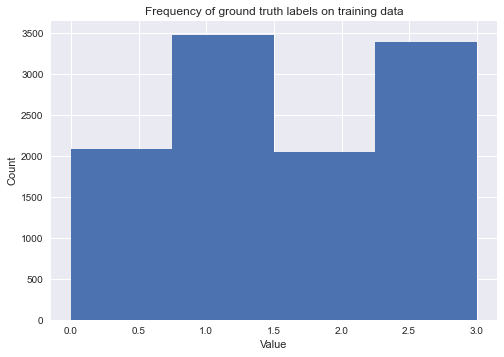

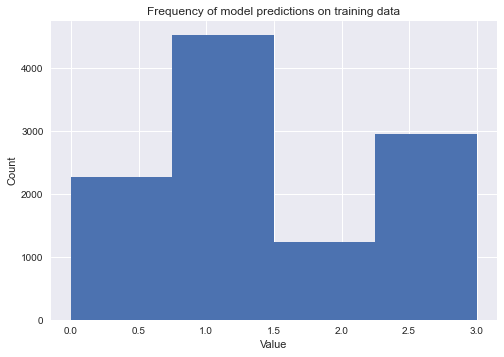

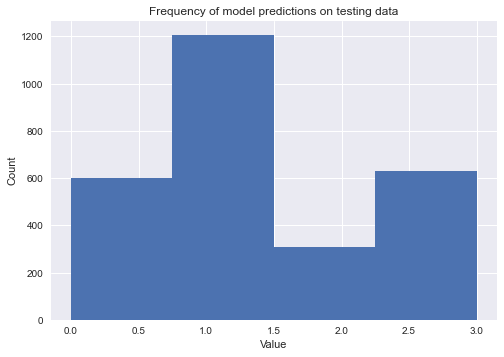

Last loss: 1.2499
Last train accuracy: 0.2696
Last test accuracy: 0.2574


In [39]:
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    x_train,                      # Training inputs
    y_train,                      # Training labels
    local_net,              # The BrainNet
    num_rule_epochs = 5,   # Number of meta-learning epochs
    num_epochs = 1,         # Number of times to process a single batch
    batch_size = 100,       # Number of samples in a batch
    learn_rate = 1e-2,      # Learning rate
    X_test = x_test,
    y_test = y_test,
    verbose = True)

## Train and Test Downstream Classification

In [40]:
x_train, y_train, x_test, y_test, dim_size = get_train_test(train_data_upstream_two_class, test_data_upstream_two_class)

In [41]:
brain_net = network.LocalNet(n = dim_size,  # number of input features (= dimension)
                             m = 4,  # number of possible labels
                             num_v = 70,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 35,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options_downstream, update_scheme = scheme_rnn)

brain_net.rnn_rule = local_net.rnn_rule
brain_net.output_rule = local_net.output_rule

In [42]:
# train downstream
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    x_train, y_train, brain_net, num_epochs=5, batch_size=100, vanilla=False, learn_rate=1e-2,
    X_test= x_test, y_test=y_test, verbose=False, stats_interval=3000, disable_backprop=True)

  0%|                                                                                         | 0/6838 [00:00<?, ?it/s]

===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
INITIAL train accuracy: 0.0645
INITIAL test accuracy: 0.0614
Epoch 1 / 5 ...


  1%|▉                                                                              | 79/6838 [00:00<00:08, 777.08it/s]


Epoch 2 / 5 ...


  2%|█▊                                                                            | 154/6838 [00:00<00:08, 768.77it/s]


Epoch 3 / 5 ...


  1%|▉                                                                              | 78/6838 [00:00<00:08, 774.81it/s]


Epoch 4 / 5 ...


  1%|▉                                                                              | 80/6838 [00:00<00:08, 786.95it/s]


Epoch 5 / 5 ...


100%|█████████████████████████████████████████████████████████████████████████████| 6838/6838 [00:08<00:00, 813.03it/s]


Last loss: 1.5411
Last train accuracy: 0.1050
Last test accuracy: 0.1081


## Generalizing from Two Classes

In [43]:
x_train, y_train, x_test, y_test, dim_size = get_train_test(train_data_upstream_two_class, test_data_upstream_two_class)

In [44]:
# relabeling to 0 or 1 as we only have 2 dimensions
y_train[y_train > 1] = 0
y_test[y_test  > 1] = 0

In [45]:
local_net = network.LocalNet(n = dim_size,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 70,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 35,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options_upstream, update_scheme = scheme_rnn)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Start meta-learning over outer (rule) epochs...


 12%|██████████▌                                                                         | 1/8 [00:05<00:39,  5.58s/it]

Acc of class 0 : 0.5905
Acc of class 1 : 0.4222
Train accuracy: 0.5063
Acc of class 0 : 0.5530
Acc of class 1 : 0.4364
Test accuracy: 0.4947
Current loss: 0.6941
Mean loss so far: 0.6941


 25%|█████████████████████                                                               | 2/8 [00:11<00:33,  5.56s/it]

Acc of class 0 : 0.7917
Acc of class 1 : 0.2315
Train accuracy: 0.5116
Acc of class 0 : 0.7651
Acc of class 1 : 0.2716
Test accuracy: 0.5183
Current loss: 0.6892
Mean loss so far: 0.6916


 38%|███████████████████████████████▌                                                    | 3/8 [00:16<00:27,  5.50s/it]

Acc of class 0 : 0.9235
Acc of class 1 : 0.1294
Train accuracy: 0.5265
Acc of class 0 : 0.9048
Acc of class 1 : 0.1364
Test accuracy: 0.5206
Current loss: 0.6862
Mean loss so far: 0.6898


 50%|██████████████████████████████████████████                                          | 4/8 [00:21<00:22,  5.51s/it]

Acc of class 0 : 0.9791
Acc of class 1 : 0.0512
Train accuracy: 0.5151
Acc of class 0 : 0.9771
Acc of class 1 : 0.0580
Test accuracy: 0.5175
Current loss: 0.6858
Mean loss so far: 0.6888


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:27<00:16,  5.57s/it]

Acc of class 0 : 0.9668
Acc of class 1 : 0.0509
Train accuracy: 0.5088
Acc of class 0 : 0.9723
Acc of class 1 : 0.0580
Test accuracy: 0.5151
Current loss: 0.6858
Mean loss so far: 0.6882


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:33<00:11,  5.61s/it]

Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
Train accuracy: 0.5000
Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
Test accuracy: 0.5000
Current loss: 0.6884
Mean loss so far: 0.6882


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:38<00:05,  5.57s/it]

Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
Train accuracy: 0.5000
Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
Test accuracy: 0.5000
Current loss: 0.6876
Mean loss so far: 0.6881


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:44<00:00,  5.58s/it]

Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
Train accuracy: 0.5000
Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
Test accuracy: 0.5000
Current loss: 0.6866
Mean loss so far: 0.6880


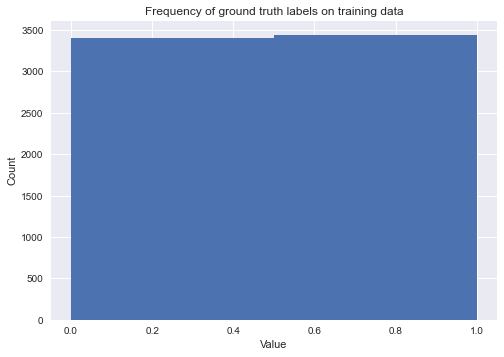

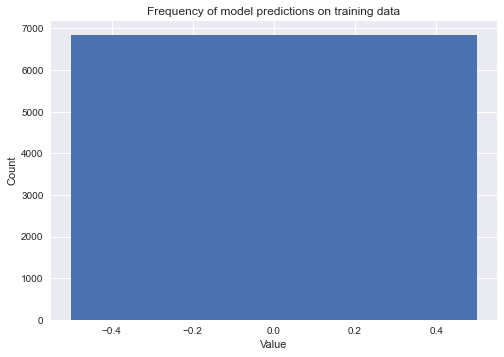

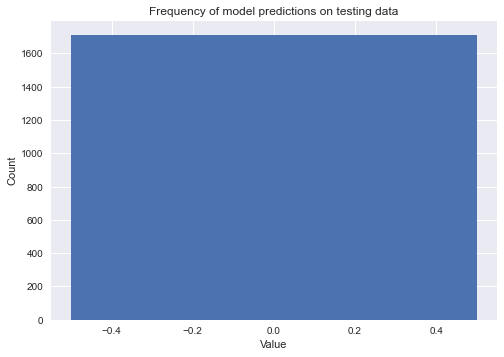

Last loss: 0.6866
Last train accuracy: 0.5000
Last test accuracy: 0.5000


In [46]:
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    x_train,                      # Training inputs
    y_train,                      # Training labels
    local_net,              # The BrainNet
    num_rule_epochs = 5,   # Number of meta-learning epochs
    num_epochs = 1,         # Number of times to process a single batch
    batch_size = 100,       # Number of samples in a batch
    learn_rate = 1e-2,      # Learning rate
    X_test = x_test,
    y_test = y_test,
    verbose = True)

In [47]:
x_train, y_train, x_test, y_test, dim_size = get_train_test(train_data_downstream, test_data_downstream)

In [48]:
brain_net = network.LocalNet(n = dim_size,  # number of input features (= dimension)
                             m = 4,  # number of possible labels
                             num_v = 70,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 35,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options_downstream, update_scheme = scheme_rnn)

brain_net.rnn_rule = local_net.rnn_rule
brain_net.output_rule = local_net.output_rule

In [49]:
# train downstream
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    x_train, y_train, brain_net, num_epochs=5, batch_size=100, vanilla=False, learn_rate=1e-2,
    X_test= x_test, y_test=y_test, verbose=False, stats_interval=3000, disable_backprop=True)

  0%|                                                                                        | 0/10988 [00:00<?, ?it/s]

===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 5 ...


  1%|▍                                                                             | 57/10988 [00:00<00:19, 560.70it/s]


Epoch 2 / 5 ...


  0%|▎                                                                             | 42/10988 [00:00<00:26, 417.23it/s]


Epoch 3 / 5 ...


  0%|▏                                                                             | 28/10988 [00:00<00:40, 272.75it/s]


Epoch 4 / 5 ...


  0%|▏                                                                             | 23/10988 [00:00<00:48, 224.05it/s]


Epoch 5 / 5 ...


100%|███████████████████████████████████████████████████████████████████████████| 10988/10988 [00:45<00:00, 241.71it/s]


Last loss: 1.4950
Last train accuracy: 0.2597
Last test accuracy: 0.2543


## Generalizing with Feedforward Models

In [101]:
x_train_upstream, y_train_upstream, x_test_upstream, y_test_upstream, dim_size_upstream = get_train_test(train_data_upstream_two_class, test_data_upstream_two_class)
# relabeling to 0 or 1 as we only have 2 dimensions
y_train_upstream[y_train_upstream > 1] = 0
y_test_upstream[y_test_upstream  > 1] = 0
dataset_up = (x_train_upstream, y_train_upstream, x_test_upstream, y_test_upstream)

In [102]:
x_train_downstream, y_train_downstream, x_test_downstream, y_test_downstream, dim_size_downstream = get_train_test(train_data_downstream, test_data_downstream)
dataset_down = (x_train_downstream, y_train_downstream, x_test_downstream, y_test_downstream)

In [103]:
# we do want to use output rules here
options_downstream = LocalNetBase.Options(
    gd_input=True,
    use_graph_rule=True,
    gd_graph_rule=False,  # Not meta-trainable anymore!
    use_output_rule=True,
    gd_output_rule=False,  # Not meta-trainable anymore!
    gd_output=False,
    use_softmax=True)

In [104]:
# Feed-forward brain config.
n_up = dim_size_upstream  # Input layer size for meta-learning.
n_down = dim_size_downstream  # Input layer size for desired task training.
m_up = 2  # Output layer size for meta-learning.
m_down = 4  # Output layer size for desired task training.
l = 2  # Number of hidden layers.
w = 70  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 35  # Number of nodes firing per layer.

# Training config.
num_runs = 1
num_rule_epochs = 10
num_epochs_upstream = 1
num_epochs_downstream = 1
downstream_backprop = True

In [121]:
# Instantiate brain factories.
brain_rnn_up_fact = lambda: LocalNet(n_up, m_up, w, p, cap, 2, options=options_upstream, update_scheme=scheme_rnn)
brain_rnn_down_fact = lambda: LocalNet(n_down, m_down, w, p, cap, 2, options=options_downstream, update_scheme=scheme_rnn)
brain_rnn_up_fact_t3 = lambda: LocalNet(n_up, m_up, w, p, cap, 3, options=options_upstream, update_scheme=scheme_rnn)
brain_rnn_down_fact_t3 = lambda: LocalNet(n_down, m_down, w, p, cap, 3, options=options_downstream, update_scheme=scheme_rnn)

brain_prepost_l2_up_fact = lambda: FFLocalNet(
    n_up, m_up, 2, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=options_upstream, update_scheme=scheme_ff)
brain_prepost_l2_down_fact = lambda: FFLocalNet(
    n_down, m_down, 2, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=options_downstream, update_scheme=scheme_ff)
brain_prepost_l3_up_fact = lambda: FFLocalNet(
    n_up, m_up, 3, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=options_upstream, update_scheme=scheme_ff)
brain_prepost_l3_down_fact = lambda: FFLocalNet(
    n_down, m_down, 3, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=options_downstream, update_scheme=scheme_ff)

brain_prepostcount_l2_up_fact = lambda: FFLocalNet(
    n_up, m_up, 2, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=options_upstream, update_scheme=scheme_ff)
brain_prepostcount_l2_down_fact = lambda: FFLocalNet(
    n_down, m_down, 2, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=options_downstream, update_scheme=scheme_ff)
brain_prepostcount_l3_up_fact = lambda: FFLocalNet(
    n_up, m_up, 3, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=options_upstream, update_scheme=scheme_ff)
brain_prepostcount_l3_down_fact = lambda: FFLocalNet(
    n_down, m_down, 3, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=options_downstream, update_scheme=scheme_ff)

brain_prepostpercent_l2_up_fact = lambda: FFLocalNet(
    n_up, m_up, 2, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=options_upstream, update_scheme=scheme_ff)
brain_prepostpercent_l2_down_fact = lambda: FFLocalNet(
    n_down, m_down, 2, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=options_downstream, update_scheme=scheme_ff)
brain_prepostpercent_l3_up_fact = lambda: FFLocalNet(
    n_up, m_up, 3, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=options_upstream, update_scheme=scheme_ff)
brain_prepostpercent_l3_down_fact = lambda: FFLocalNet(
    n_down, m_down, 3, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=options_downstream, update_scheme=scheme_ff)

In [106]:
# modified version of evaluate_up_down() in eval utils, this should probably belong there 
def evaluate_up_down_custom(brain_up_fact, brain_down_fact, n_up, n_down,
                     dataset_up, dataset_down = None, downstream_backprop=False,
                     num_runs=1, num_rule_epochs=10, num_epochs_upstream=1, num_epochs_downstream=1,
                     num_downstream_subruns=1,
                     get_model=False, min_upstream_acc=0.7, batch_size=100, learn_rate=1e-2,
                     use_gpu=False,
                     upstream_only=False, return_upstream_brains=False):
    '''
    Evaluates a PAIR of brains on the quality of meta-learning
    and rule interpretations by training with transferred rules.

    Args:
        brain_up_fact: Calling this will create a new instance of the network to meta-learn.
        brain_down_fact: Calling this will create a new instance of the network to train.
        dataset_up: Upstream dataset of form (X_train, y_train, X_test, y_test)
        dataset_down: If None, keep the same dataset instance. Otherwise, downstream dataset.
        downstream_backprop: Use backprop for the direct GD layers downstream?
            Recommended True, since the downstream weights will remain randomly initialized otherwise.
        min_upstream_acc: Keep meta-learning until we find a good random initialization with
            this final test balanced accuracy.

    Returns:
        (multi_stats_up, multi_stats_down) or ((multi_stats_up, multi_stats_down), brain_down).
        Both are lists of length num_runs.
    '''
    if (dataset_down is None) != (n_down is None):
        raise ValueError('The nullness of dataset_down does not agree with that of n_down.')

    multi_stats_up = []
    multi_stats_down = []  # Will remain empty if upstream_only.
    upstream_brains = []

    for run in range(num_runs):
        print()
        print(f'Run {run + 1} / {num_runs}...')

        # Upstream (once per run).
        success = False
        failures = 0
        while not success and failures < 3:
            brain_up = brain_up_fact()  # NOTE: Some initializations are unlucky.

            print('Meta-learning on upstream data...')
            X_train, y_train, X_test, y_test = dataset_up
            stats_up = metalearn_rules(
                X_train, y_train, brain_up, num_rule_epochs=num_rule_epochs,
                num_epochs=num_epochs_upstream, batch_size=batch_size, learn_rate=learn_rate,
                X_test=X_test, y_test=y_test, verbose=False, use_gpu=use_gpu)

            success = (stats_up[2][-1] >= min_upstream_acc)
            if not success:
                failures += 1
                print(
                    f'Final upstream test acc {stats_up[2][-1]:.4f} not high enough, retrying... (failures = {failures})')

        # Retain network e.g. for extracting rules later.
        if return_upstream_brains:
            upstream_brains.append(brain_up)
        
        if not upstream_only:

            # Downstream (subrun loop).
            for subrun in range(num_downstream_subruns):

                if num_downstream_subruns > 1:
                    print()
                    print(f'Run {run + 1} / {num_runs}...')
                    print(f'Subrun {subrun + 1} / {num_downstream_subruns}...')

                # Transfer rules.
                brain_down = brain_down_fact()
                if isinstance(brain_down, FFLocalNet):
                    # FF-ANN.
                    brain_down.copy_rules(brain_up, output_rule=brain_down.options.use_output_rule)
                else:
                    # RNN.
                    try:
                        if brain_down.options.use_graph_rule:
                            brain_down.set_rnn_rule(brain_up.get_rnn_rule())
                        if brain_down.options.use_output_rule:
                            brain_down.set_output_rule(brain_up.get_output_rule())
                    except:
                        print('FALLBACK: direct assignment of rules...')
                        if downstream_backprop:
                            print('=> WARNING: Rules might still be updated by GD this way')
                        brain_down.rnn_rule = brain_up.rnn_rule
                        brain_down.output_rule = brain_up.output_rule

                # Downstream (within subrun).
                if dataset_down is not None and n_down is not None:
                    print('Training NEW brain instance on downstream data...')
                    X_train, y_train, X_test, y_test = dataset_down
                else:
                    print('Training NEW brain instance on the same dataset instance...')
                stats_down = train_downstream(
                    X_train, y_train, brain_down, num_epochs=num_epochs_downstream,
                    batch_size=batch_size, vanilla=False, learn_rate=learn_rate,
                    X_test=X_test, y_test=y_test, verbose=False,
                    stats_interval=300, disable_backprop=not(downstream_backprop),
                    use_gpu=use_gpu)

                # Save this subrun.
                multi_stats_down.append(stats_down)

        # Save this run.
        multi_stats_up.append(stats_up)

        print()

    if get_model:
        # Return latest downstream network.
        return (multi_stats_up, multi_stats_down), brain_down
    elif return_upstream_brains:
        # Return all upstream networks.
        return (multi_stats_up, multi_stats_down), upstream_brains
    else:
        return (multi_stats_up, multi_stats_down)

In [107]:
print('==== Interpretation: PrePost, 2 hidden layers (universal) ====')
stats_prepost_l2_up, stats_prepost_l2_down = evaluate_up_down_custom(
    brain_prepost_l2_up_fact, brain_prepost_l2_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)
print('==== Interpretation: PrePost, 3 hidden layers (universal) ====')
stats_prepost_l3_up, stats_prepost_l3_down = evaluate_up_down_custom(
    brain_prepost_l3_up_fact, brain_prepost_l3_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

==== Interpretation: PrePost, 2 hidden layers (universal) ====

Run 1 / 1...
Meta-learning on upstream data...


  0%|                                                                                        | 0/10988 [00:00<?, ?it/s]

Last loss: 0.6273
Last train accuracy: 0.5417
Last test accuracy: 0.5202
Training NEW brain instance on downstream data...
INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Last loss: 1.4192
Last train accuracy: 0.2841
Last test accuracy: 0.2739

==== Interpretation: PrePost, 3 hidden layers (universal) ====

Run 1 / 1...
Meta-learning on upstream data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:51<00:00, 59.16s/it]


Last loss: 0.6450
Last train accuracy: 0.5202
Last test accuracy: 0.5348
Training NEW brain instance on downstream data...
INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████| 10988/10988 [02:16<00:00, 80.54it/s]


Last loss: 1.4458
Last train accuracy: 0.2966
Last test accuracy: 0.2832



In [108]:
print('==== Interpretation: PrePostCount, 2 hidden layers (universal) ====')
stats_prepostcount_l2_up, stats_prepostcount_l2_down = evaluate_up_down_custom(
    brain_prepostcount_l2_up_fact, brain_prepostcount_l2_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)
print('==== Interpretation: PrePostCount, 3 hidden layers (universal) ====')
stats_prepostcount_l3_up, stats_prepostcount_l3_down = evaluate_up_down_custom(
    brain_prepostcount_l3_up_fact, brain_prepostcount_l3_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

==== Interpretation: PrePostCount, 2 hidden layers (universal) ====

Run 1 / 1...
Meta-learning on upstream data...


  0%|                                                                                        | 0/10988 [00:00<?, ?it/s]

Last loss: 0.6744
Last train accuracy: 0.5436
Last test accuracy: 0.5509
Training NEW brain instance on downstream data...
INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Last loss: 1.4192
Last train accuracy: 0.2991
Last test accuracy: 0.2801

==== Interpretation: PrePostCount, 3 hidden layers (universal) ====

Run 1 / 1...
Meta-learning on upstream data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:26<00:00, 68.63s/it]


Last loss: 0.6931
Last train accuracy: 0.5000
Last test accuracy: 0.5000
Training NEW brain instance on downstream data...
INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████| 10988/10988 [02:41<00:00, 68.00it/s]


Last loss: 1.3863
Last train accuracy: 0.2500
Last test accuracy: 0.2500



In [109]:
print('==== Interpretation: PrePostPercent, 2 hidden layers (universal) ====')
stats_prepostpercent_l2_up, stats_prepostpercent_l2_down = evaluate_up_down_custom(
    brain_prepostpercent_l2_up_fact, brain_prepostpercent_l2_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)
print('==== Interpretation: PrePostPercent, 3 hidden layers (universal) ====')
stats_prepostpercent_l3_up, stats_prepostpercent_l3_down = evaluate_up_down_custom(
    brain_prepostpercent_l3_up_fact, brain_prepostpercent_l3_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

==== Interpretation: PrePostPercent, 2 hidden layers (universal) ====

Run 1 / 1...
Meta-learning on upstream data...


  0%|                                                                                        | 0/10988 [00:00<?, ?it/s]

Last loss: 0.6307
Last train accuracy: 0.4921
Last test accuracy: 0.5048
Training NEW brain instance on downstream data...
INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Last loss: 1.4564
Last train accuracy: 0.3163
Last test accuracy: 0.2840

==== Interpretation: PrePostPercent, 3 hidden layers (universal) ====

Run 1 / 1...
Meta-learning on upstream data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:39<00:00, 69.92s/it]


Last loss: 0.6509
Last train accuracy: 0.5320
Last test accuracy: 0.5350
Training NEW brain instance on downstream data...
INITIAL train accuracy: 0.2500


  0%|                                                                                | 7/10988 [00:00<02:45, 66.26it/s]

INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████| 10988/10988 [02:44<00:00, 66.79it/s]


Last loss: 1.4511
Last train accuracy: 0.2888
Last test accuracy: 0.2795



In [110]:
print('==== Original RNN ====')
stats_rnn_up, stats_rnn_down = evaluate_up_down_custom(
    brain_rnn_up_fact, brain_rnn_down_fact, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

==== Original RNN ====

Run 1 / 1...
Meta-learning on upstream data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:55<00:00, 29.57s/it]
..\LocalNetBase.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()


Last loss: 0.6904
Last train accuracy: 0.4934
Last test accuracy: 0.4969
Training NEW brain instance on downstream data...


  0%|                                                                                | 8/10988 [00:00<02:18, 79.47it/s]

INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████| 10988/10988 [02:21<00:00, 77.74it/s]


Last loss: 1.4305
Last train accuracy: 0.2687
Last test accuracy: 0.2477



In [122]:
print('==== Original RNN T = 3====')
stats_rnn_up_t3, stats_rnn_down_t3 = evaluate_up_down_custom(
    brain_rnn_up_fact_t3, brain_rnn_down_fact_t3, n_up, n_down,
    dataset_up=dataset_up, dataset_down=dataset_down,
    downstream_backprop=downstream_backprop, num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream, min_upstream_acc=0.25)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

==== Original RNN T = 3====

Run 1 / 1...
Meta-learning on upstream data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:58<00:00, 35.86s/it]
..\LocalNetBase.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()


Last loss: 0.6928
Last train accuracy: 0.4997
Last test accuracy: 0.5011
Training NEW brain instance on downstream data...


  0%|                                                                                | 7/10988 [00:00<02:47, 65.64it/s]

INITIAL train accuracy: 0.2500
INITIAL test accuracy: 0.2500
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████| 10988/10988 [02:52<00:00, 63.85it/s]


Last loss: 1.4742
Last train accuracy: 0.2322
Last test accuracy: 0.2500



In [111]:
brain_vanilla = FFBrainNet(
    n_down, m_down, l, w, p, cap, full_gd=True)
print('==== Vanilla ====')
stats_vanilla = train_downstream(
    x_train_downstream, y_train_downstream, brain_vanilla, num_epochs=num_epochs_downstream,
    batch_size=100, vanilla=True, learn_rate=1e-2,
    X_test=x_test_downstream, y_test=y_test_downstream, verbose=False, stats_interval=500)

==== Vanilla ====
INITIAL train accuracy: 0.2471
INITIAL test accuracy: 0.2463
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 28.61it/s]


Last loss: 1.4262
Last train accuracy: 0.2537
Last test accuracy: 0.2492


In [123]:
# t = 3 here
brain_vanilla = FFBrainNet(
    n_down, m_down, 3, w, p, cap, full_gd=True)
print('==== Vanilla ====')
stats_vanilla_t3 = train_downstream(
    x_train_downstream, y_train_downstream, brain_vanilla, num_epochs=num_epochs_downstream,
    batch_size=100, vanilla=True, learn_rate=1e-2,
    X_test=x_test_downstream, y_test=y_test_downstream, verbose=False, stats_interval=500)

==== Vanilla ====
INITIAL train accuracy: 0.2689


  0%|                                                                                          | 0/109 [00:00<?, ?it/s]

INITIAL test accuracy: 0.2823
Epoch 1 / 1 ...


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:05<00:00, 18.82it/s]


Last loss: 1.3901
Last train accuracy: 0.2992
Last test accuracy: 0.2801


In [124]:
agg_stats_prepost_l2_up = convert_multi_stats_uncertainty(stats_prepost_l2_up)
agg_stats_prepost_l2_down = convert_multi_stats_uncertainty(stats_prepost_l2_down)
agg_stats_prepost_l3_up = convert_multi_stats_uncertainty(stats_prepost_l3_up)
agg_stats_prepost_l3_down = convert_multi_stats_uncertainty(stats_prepost_l3_down)
agg_stats_prepostcount_l2_up = convert_multi_stats_uncertainty(stats_prepostcount_l2_up)
agg_stats_prepostcount_l2_down = convert_multi_stats_uncertainty(stats_prepostcount_l2_down)
agg_stats_prepostcount_l3_up = convert_multi_stats_uncertainty(stats_prepostcount_l3_up)
agg_stats_prepostcount_l3_down = convert_multi_stats_uncertainty(stats_prepostcount_l3_down)
agg_stats_prepostpercent_l2_up = convert_multi_stats_uncertainty(stats_prepostpercent_l2_up)
agg_stats_prepostpercent_l2_down = convert_multi_stats_uncertainty(stats_prepostpercent_l2_down)
agg_stats_prepostpercent_l3_up = convert_multi_stats_uncertainty(stats_prepostpercent_l3_up)
agg_stats_prepostpercent_l3_down = convert_multi_stats_uncertainty(stats_prepostpercent_l3_down)
agg_stats_rnn_up = convert_multi_stats_uncertainty(stats_rnn_up)
agg_stats_rnn_down = convert_multi_stats_uncertainty(stats_rnn_down)
agg_stats_rnn_up_t3 = convert_multi_stats_uncertainty(stats_rnn_up_t3)
agg_stats_rnn_down_t3 = convert_multi_stats_uncertainty(stats_rnn_down_t3)

Saving figure to: figs/generalization_all2_nlp_generalization_2layers


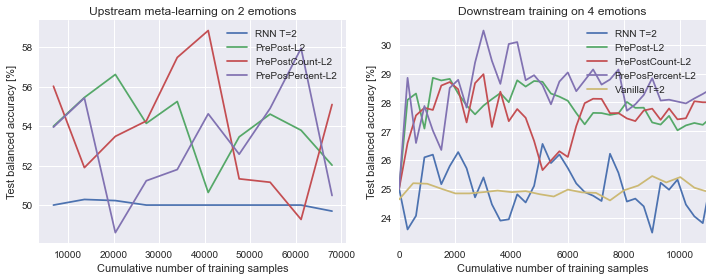

In [126]:
# Plot to compare all.
all_stats_up = [agg_stats_rnn_up,
                agg_stats_prepost_l2_up,
                agg_stats_prepostcount_l2_up,
                agg_stats_prepostpercent_l2_up,
                None]
all_stats_down = [agg_stats_rnn_down,
                  agg_stats_prepost_l2_down,
                  agg_stats_prepostcount_l2_down,
                  agg_stats_prepostpercent_l2_down,
                  stats_vanilla]
labels = ['RNN T=2', 'PrePost-L2', 'PrePostCount-L2', 'PrePosPercent-L2', 'Vanilla T=2']
plot_compare_models(all_stats_up, all_stats_down, labels,
                    'Upstream meta-learning on 2 emotions',
                    'Downstream training on 4 emotions',
                    'figs/generalization_all2_nlp_generalization_2layers')

Saving figure to: figs/generalization_all2_nlp_generalization_3layers


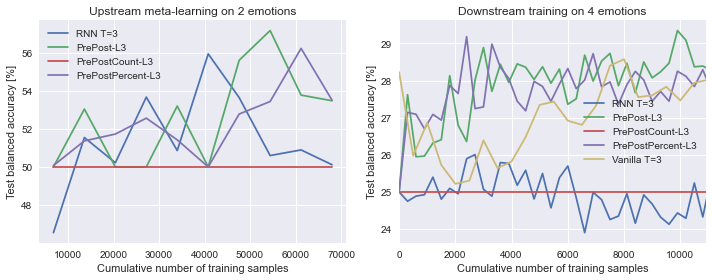

In [130]:
# Plot to compare all.
all_stats_up = [agg_stats_rnn_up_t3,
                agg_stats_prepost_l3_up,
                agg_stats_prepostcount_l3_up,
                agg_stats_prepostpercent_l3_up,
                None]
all_stats_down = [agg_stats_rnn_down_t3,
                  agg_stats_prepost_l3_down,
                  agg_stats_prepostcount_l3_down,
                  agg_stats_prepostpercent_l3_down,
                  stats_vanilla_t3]
labels = ['RNN T=3', 'PrePost-L3', 'PrePostCount-L3', 'PrePostPercent-L3', 'Vanilla T=3']
plot_compare_models(all_stats_up, all_stats_down, labels,
                    'Upstream meta-learning on 2 emotions',
                    'Downstream training on 4 emotions',
                    'figs/generalization_all2_nlp_generalization_3layers')